In [123]:
from imutils import paths
import os
import gc
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from sklearn.preprocessing import LabelBinarizer
#from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pylab as plt
from sklearn.metrics import classification_report, roc_auc_score, auc
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve
import itertools

In [124]:
INIT_LR = 1e-3
EPOCHS = 32
BS = 32

print("[INFO] loading images...")
imagePaths = list(paths.list_images(".\\xraydata"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the image, swap color channels, and resize it to be a fixed
    # 50x50 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

data = np.array(data) / 255.0
labels = np.array(labels)



[INFO] loading images...


In [125]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels.shape

(250, 2)

In [126]:
train_X, test_X, train_Y, test_Y = train_test_split(data, labels, test_size=0.3, random_state=4)

In [127]:
trainAug = ImageDataGenerator(
       featurewise_center=True,
       featurewise_std_normalization=True,
       rotation_range=20,
       horizontal_flip=True,  # randomly flip images
       vertical_flip=True,    # randomly flip images  
       fill_mode="nearest"
    )

In [128]:
ImageDataGenerator?

In [129]:
# Initialising the CNN
model = Sequential()

# Step 1 - Convolution
model.add(Conv2D(32, (3, 3), input_shape = (224, 224, 3), activation = 'relu'))

# Step 2 - Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
model.add(Flatten())

# Step 4 - Full connection
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 2, activation = 'sigmoid'))

# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [130]:
print(len(model.layers))
model.summary()
gc.collect()

7
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               23888000  
_________________________________________________________________
dense_14 (Dense)             (None, 2)              

20

In [131]:
H = model.fit(
    trainAug.flow(train_X, train_Y, batch_size=BS),
    #train_X, train_Y,
    steps_per_epoch=len(train_X) // BS,
    validation_data=(test_X, test_Y),
    validation_steps=len(test_X) // BS,
    epochs=EPOCHS)

Epoch 1/32


C:\Users\shahm\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\shahm\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


5/5 [==============================] - 4s 792ms/step - loss: 1.9521 - accuracy: 0.5156 - val_loss: 0.7993 - val_accuracy: 0.5867
Epoch 2/32
5/5 [==============================] - 3s 599ms/step - loss: 0.6658 - accuracy: 0.5913 - val_loss: 0.6937 - val_accuracy: 0.4600
Epoch 3/32
5/5 [==============================] - 3s 684ms/step - loss: 0.6887 - accuracy: 0.5875 - val_loss: 0.6757 - val_accuracy: 0.5867
Epoch 4/32
5/5 [==============================] - 3s 546ms/step - loss: 0.6780 - accuracy: 0.6270 - val_loss: 0.6698 - val_accuracy: 0.5867
Epoch 5/32
5/5 [==============================] - 3s 655ms/step - loss: 0.6834 - accuracy: 0.5625 - val_loss: 0.6796 - val_accuracy: 0.6067
Epoch 6/32
5/5 [==============================] - 3s 602ms/step - loss: 0.6660 - accuracy: 0.6189 - val_loss: 0.6537 - val_accuracy: 0.5867
Epoch 7/32
5/5 [==============================] - 3s 630ms/step - loss: 0.6409 - accuracy: 0.6573 - val_loss: 0.6589 - val_accuracy: 0.6000
Epoch 8/32
5/5 [===============

In [133]:
predIdxs = model.predict(test_X)

In [134]:
predIdxs = np.argmax(predIdxs,axis=1) 

In [135]:
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

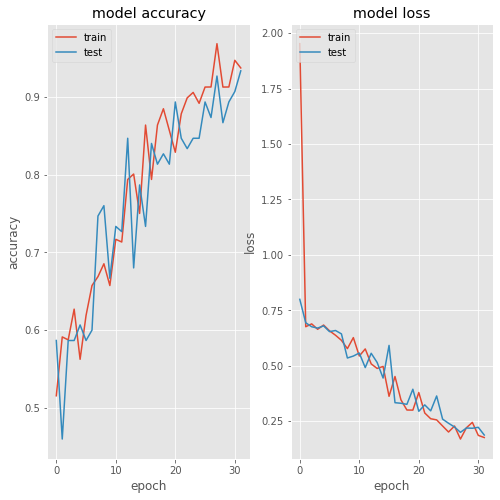

In [136]:
plot_learning_curve(H)
plt.show()

In [137]:
print(classification_report(test_Y.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

      benign       1.00      0.84      0.91        31
   malignant       0.90      1.00      0.95        44

    accuracy                           0.93        75
   macro avg       0.95      0.92      0.93        75
weighted avg       0.94      0.93      0.93        75



[[26  5]
 [ 0 44]]


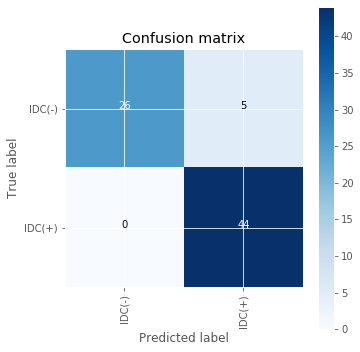

[[26  5]
 [ 0 44]]
acc: 0.9333
sensitivity: 0.8387
specificity: 1.0000
              precision    recall  f1-score   support

         ID-       1.00      0.84      0.91        31
         ID+       0.90      1.00      0.95        44

    accuracy                           0.93        75
   macro avg       0.95      0.92      0.93        75
weighted avg       0.94      0.93      0.93        75



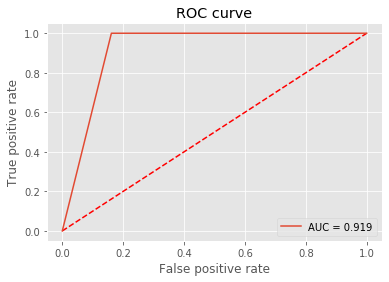

0.46831290513922746
0.44188220630710323


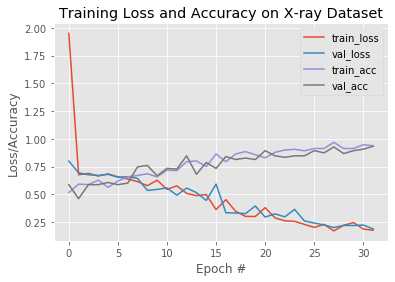

In [138]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(test_Y.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

confusion_matrixx = metrics.confusion_matrix(y_true=test_Y.argmax(axis=1), y_pred=predIdxs)
print(confusion_matrixx)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
plot_confusion_matrix(cm, classes = list(dict_characters.values())) 
plt.show()
plt.close()
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on X-ray Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot")
plt.close()
tg_names=['ID-','ID+']
report = metrics.classification_report(test_Y.argmax(axis=1), predIdxs, target_names=tg_names)
print(report)  

roc_log = roc_auc_score(test_Y.argmax(axis=1), predIdxs)
false_positive_rate, true_positive_rate, threshold = roc_curve(test_Y.argmax(axis=1), predIdxs)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

print(np.mean(H.history["loss"]))
print(np.mean(H.history["val_loss"]))

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on X-ray Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")